In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cvxpy as cp
from docplex.mp.model import Model
import os
import warnings

In [12]:
# Configuration

warnings.filterwarnings("ignore", category=UserWarning, module='cvxpy')

ampds_path = "../dataverse_files" 

# simulation parameters
SAMPLE_DATE = "2013-07-20"
START_TIME = f"{SAMPLE_DATE} 19:00:00"
END_TIME   = f"{SAMPLE_DATE} 20:00:00"

# hyperparameters
ETA = 0.5                 # KL-Divergence robustness parameter 
MAX_TRAIN_SAMPLES = 50000  


def load_ampds_file(filename):
    path = os.path.join(ampds_path, filename)
    if not os.path.exists(path):
        print(f"error: {filename} not found.")
        return None
    df = pd.read_csv(path, usecols=['unix_ts', 'P'])
    df.rename(columns={'P': 'W'}, inplace=True)
    df['datetime'] = pd.to_datetime(df['unix_ts'], unit='s')
    df.set_index('datetime', inplace=True)
    df.drop(columns=['unix_ts'], inplace=True)
    df.sort_index(inplace=True)
    return df

whe = load_ampds_file("Electricity_WHE.csv") # Aggregate
bme = load_ampds_file("Electricity_BME.csv") # Basement
fre = load_ampds_file("Electricity_FRE.csv") # Fridge
tve = load_ampds_file("Electricity_TVE.csv") # TV

# we select the test data
timeRange = slice(START_TIME, END_TIME)
test_bme = bme.loc[timeRange]['W'].values
test_fre = fre.loc[timeRange]['W'].values
test_tve = tve.loc[timeRange]['W'].values

# synthetic aggregate (sum of modeled appliances only) to validate MILP logic
testAgg = test_bme + test_fre + test_tve

print(f"Test Set: {len(testAgg)} samples. The Max Total Power: {testAgg.max():.1f}W")

Test Set: 61 samples. The Max Total Power: 135.0W


In [13]:
#KL-DR-LR feature extraction

def solve_kl_dr_lr(data_vector, eta=0.1):

    K = len(data_vector)
    if K < 10: return 0, np.mean(data_vector) if K > 0 else 0
    
    P_sorted = np.sort(data_vector)
    
    
    indices = np.arange(1, K + 1).reshape(-1, 1)
    ones = np.ones((K, 1))
    X_mat = np.hstack((indices, ones)) 
    
    #variables and robust Term
    
    beta = cp.Variable(2) 
    b = cp.Variable(K)
    robustTerm = np.sqrt(2 * eta) * cp.norm(beta, 2)
    
    #constraints 
    regression_line = X_mat @ beta
    constraints = [
        P_sorted - regression_line + robustTerm <= b,
        -(P_sorted - regression_line) + robustTerm <= b,
        b >= 0
    ]
    
    #Objective
    objective = cp.Minimize(cp.sum(b) / K)
    
    problem = cp.Problem(objective, constraints)
    try:
        problem.solve(solver=cp.SCS, eps=1e-3)
    except:
        try:
            problem.solve(solver=cp.ECOS)
        except:
            return 0, np.mean(data_vector)

    if beta.value is None: return 0, np.mean(data_vector)
    return beta.value[0], beta.value[1]



appliances = ['BME', 'FRE', 'TVE']
datasets = [bme, fre, tve]
numStates = [3, 3, 2] 
features = {}

for name, df, m_i in zip(appliances, datasets, numStates):
    print(f"extracting features for {name} ")
    
    # K-Means clustering
    
    X_all = df['W'].values
    if len(X_all) > MAX_TRAIN_SAMPLES:
        
        rng = np.random.RandomState(42)
        X_sample = rng.choice(X_all, MAX_TRAIN_SAMPLES, replace=False).reshape(-1, 1)
    else:
        X_sample = X_all.reshape(-1, 1)
        
    kmeans = KMeans(n_clusters=m_i, random_state=42, n_init=10)
    
    labels = kmeans.fit_predict(X_sample)
    
    state_feats = []
    
    for j in range(m_i):
        cluster_data = X_sample[labels == j].flatten()

        
        if len(cluster_data) < 10:
            state_feats.append({'id':j, 'lower':0, 'upper':0, 'avg':0, 'pup':0, 'pdown':0, 'C':1000})
            continue

        #Power Bounds
        
        b1, b2 = solve_kl_dr_lr(cluster_data, eta=ETA)
        K_len = len(cluster_data)
        
        P_upper = b1 * K_len + b2
        P_lower = b2
        P_avg = cluster_data.mean()
        
        #Ramp Features
        
        diffs = np.diff(cluster_data)
        
        ups = diffs[diffs > 0]
        if len(ups) > 5:
            if len(ups) > 1000: ups = np.random.choice(ups, 1000)


                
            b1_u, b2_u = solve_kl_dr_lr(ups, eta=ETA)
            P_ramp_up = b1_u * len(ups) + b2_u
        else:
            P_ramp_up = 0
            
        downs = np.abs(diffs[diffs < 0])
        if len(downs) > 5:
            if len(downs) > 1000: downs = np.random.choice(downs, 1000)

                
            b1_d, b2_d = solve_kl_dr_lr(downs, eta=ETA)
            P_ramp_down = b1_d * len(downs) + b2_d
        else:
            P_ramp_down = 0
            
        #The Penalty Parameter C_ij
        
        C_val = len(X_sample) / len(cluster_data)
        
        state_feats.append({
            'id': j,
            'lower': max(0, P_lower),
            'upper': P_upper,
            'avg': P_avg,
            'pup': max(0, P_ramp_up),
            'pdown': max(0, P_ramp_down),
            'C': C_val
        })
        
    state_feats.sort(key=lambda x: x['avg'])
    features[name] = state_feats
    print(f"  > state avgs: {[round(s['avg'],1) for s in state_feats]}")

extracting features for BME 
  > state avgs: [np.float64(3.0), np.float64(274.4), np.float64(339.0)]
extracting features for FRE 
  > state avgs: [np.float64(110.2), np.float64(181.1), np.float64(365.1)]
extracting features for TVE 
  > state avgs: [np.float64(24.1), np.float64(214.7)]


In [14]:
#The Two stage MILP model


mdl = Model("TwoStage_NILM")
N_apps = len(appliances)
T = len(testAgg)
max_m = max(numStates)
featList = [features[app] for app in appliances]
Lambda = 1.0 

# variables
u = mdl.binary_var_cube(N_apps, max_m, T, name="u")

s = mdl.binary_var_cube(N_apps, max_m, T, name="s")


P_avg = mdl.continuous_var_cube(N_apps, max_m, T, lb=0, name="P_avg")
eps1 = mdl.continuous_var_list(T, lb=0, name="eps1")

# objective
penalty_expr = []
for i in range(N_apps):
    for j in range(len(featList[i])):
        C_ij = featList[i][j]['C']
        for t in range(T):
            change = mdl.abs(u[i,j,t] - u[i,j,t-1]) if t > 0 else u[i,j,t]
            penalty_expr.append( C_ij * (s[i,j,t] + change) )

mdl.minimize(mdl.sum(eps1) + Lambda * mdl.sum(penalty_expr))



# constraints
for t in range(T):
    # absolute Error
    sum_est = mdl.sum(P_avg[i,j,t] for i in range(N_apps) for j in range(len(featList[i])))
    mdl.add_constraint(eps1[t] >= testAgg[t] - sum_est)
    mdl.add_constraint(eps1[t] >= sum_est - testAgg[t])
    
    for i in range(N_apps):
        # state limit
        mdl.add_constraint(mdl.sum(u[i,j,t] for j in range(len(featList[i]))) <= 1)

for i in range(N_apps):
    for j, props in enumerate(featList[i]):
        for t in range(T):
            #Power Bounds
            mdl.add_constraint(P_avg[i,j,t] >= props['lower'] * u[i,j,t])
            mdl.add_constraint(P_avg[i,j,t] <= props['upper'] * u[i,j,t])

            
            
            #State Change
            if t > 0:
                mdl.add_constraint(u[i,j,t] - u[i,j,t-1] <= s[i,j,t])
            else:
                mdl.add_constraint(u[i,j,t] <= s[i,j,t])
            
            #ramping
            if t > 0:
                mdl.add_constraint(
                    P_avg[i,j,t] - P_avg[i,j,t-1] <= 
                    s[i,j,t] * props['upper'] + u[i,j,t] * props['pup']
                )
                rhs = u[i,j,t-1] * props['upper'] - \
                      (u[i,j,t] - s[i,j,t]) * (props['upper'] - props['pdown'])
                mdl.add_constraint(P_avg[i,j,t-1] - P_avg[i,j,t] <= rhs)

print("solving...")

solving...


Version identifier: 22.1.1.0 | 2022-11-27 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 8108.000000 after 0.00 sec. (0.27 ticks)
Tried aggregator 2 times.
MIP Presolve eliminated 1386 rows and 1143 columns.
MIP Presolve modified 480 coefficients.
Aggregator did 8 substitutions.
Reduced MIP has 2775 rows, 2477 columns, and 10246 nonzeros.
Reduced MIP has 968 binaries, 0 generals, 480 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (10.02 ticks)
Probing time = 0.00 sec. (0.34 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2775 rows, 2477 columns, and 10246 nonzeros.
Reduced MIP has 968 binaries, 0 generals, 480 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (6.79 ticks)
Probing time = 0.00 sec. (0.34 ticks)
Clique table members: 183.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.53 sec. (40.7

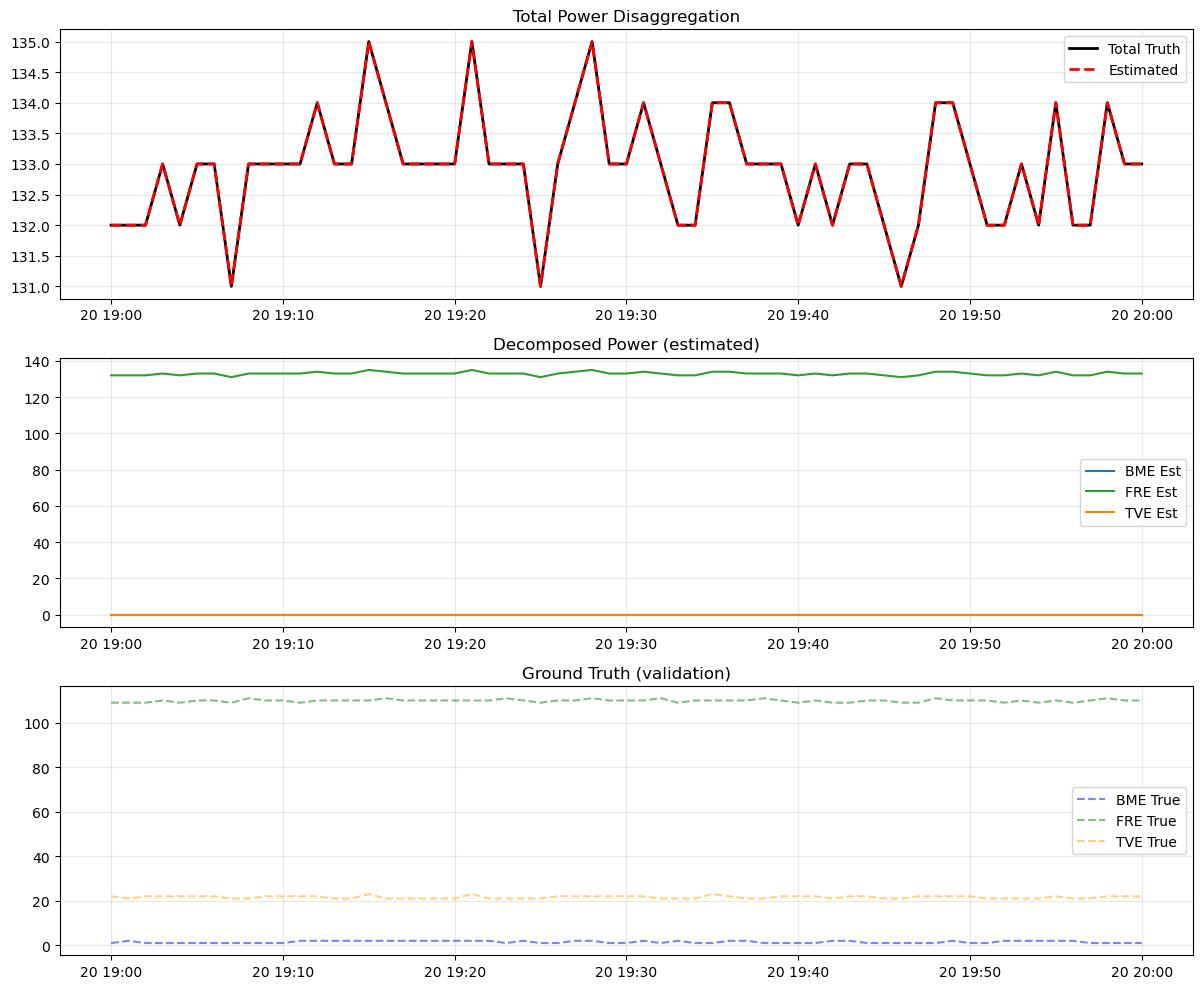

In [15]:
# Solve and results

sol = mdl.solve(log_output=True)

if sol:
    print(f"\n solution found. Objective: {sol.get_objective_value():.4f}")
    
    
    estTotal = np.zeros(T)
    estApps = {app: np.zeros(T) for app in appliances}
    for t in range(T):
        for i, app in enumerate(appliances):
            for j in range(len(features[app])):
                val = sol.get_value(P_avg[i,j,t])
                estApps[app][t] += val
                estTotal[t] += val
            
    # accuracy
    acc = 1 - (np.sum(np.abs(estTotal - testAgg)) / (2 * np.sum(testAgg)))
    print(f"accuracy: {acc*100:.2f}%")

    # plotting
    time_index = pd.date_range(start=START_TIME, periods=T, freq='min')
    plt.figure(figsize=(12, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(time_index, testAgg, 'k-', linewidth=2, label='Total Truth')
    plt.plot(time_index, estTotal, 'r--', linewidth=2, label='Estimated')
    plt.title("Total Power Disaggregation")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 1, 2)
    colors = ['tab:blue', 'tab:green', 'tab:orange']
    for i, app in enumerate(appliances):
        plt.plot(time_index, estApps[app], color=colors[i], label=f'{app} Est')
    plt.title("Decomposed Power (estimated)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(3, 1, 3)
    plt.plot(time_index, test_bme, 'b--', alpha=0.5, label='BME True')
    
    plt.plot(time_index, test_fre, 'g--', alpha=0.5, label='FRE True')

    
    plt.plot(time_index, test_tve, 'orange', alpha=0.5, linestyle='--', label='TVE True')
    plt.title("Ground Truth (validation)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("solve failed")